# Sampling from the von Mises - Fisher distribution

The von Mises - Fisher distribution is a probability distribution on the surface of a unit hypersphere of N dimensions: 

<div><center>
    $f_N(x ; \mu, \kappa)$
<center></div>

Where:
* $\mu$ is the mean direction 
* $\kappa$ is the concentration parameter

Wikipedia page: https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution 

Code used in this example is based on [this](https://stats.stackexchange.com/questions/156729/sampling-from-von-mises-fisher-distribution-in-python) and [this](https://github.com/clara-labs/spherecluster/blob/develop/spherecluster/util.py).

In [1]:
%matplotlib inline
import numpy as np
import sys
from vMF import *

## For ${\rm I\!R}^3$

For N = 3 dimensions, the von Mises - Fisher distribution is defined on the surface of a sphere.

In [5]:
# specify mu as a some 3D vector
mu = [2, -2, 3]

# normalise to a unit vector 
norm = np.linalg.norm(mu)
mu = mu / norm
print ('average direction:', mu)

average direction: [ 0.48507125 -0.48507125  0.72760688]


In [6]:
# class to store sample coordinates 
class Coord3D():
    def __init__(self, sample, kappa):
        self.x = np.transpose(sample)[0]
        self.y = np.transpose(sample)[1]
        self.z = np.transpose(sample)[2]
        self.kappa = kappa

In [7]:
# sample from vMF for a range of kappa
kappa = [1, 10, 100]
num_samples = 200
samples = []
for k in kappa:
    sample = sample_vMF(mu, k, num_samples)
    # revert from unit vector to vector
    sample = sample * norm
    samples.append(Coord3D(sample, k))

AttributeError: 'numpy.ndarray' object has no attribute 'x'

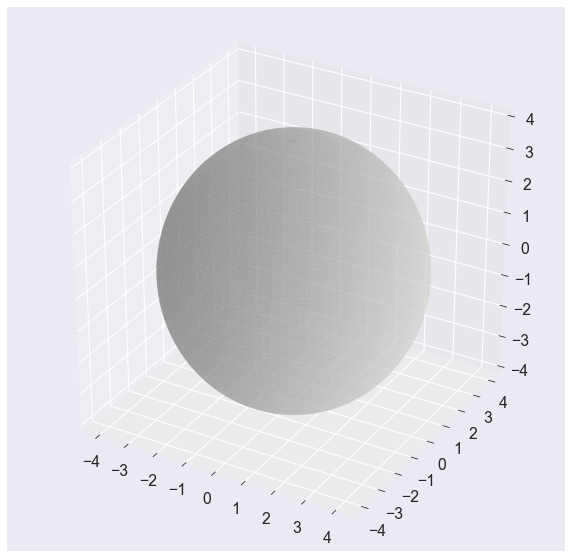

In [14]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('dark')
# have a look on a sphere with radius = norm

def make_sphere():
    r = norm - 0.1 # subtract a small amount to show points on surface
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0 * pi:100j]
    x = r * sin(phi) * cos(theta)
    y = r * sin(phi) * sin(theta)
    z = r * cos(phi)
    return x, y, z

x_circ, y_circ, z_circ = make_sphere()

# plot generated points on a unit * norm sphere
fig = plt.figure(figsize = [10, 10])
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(x_circ, y_circ, z_circ,  
                rstride = 1, cstride = 1, 
                color = sns.xkcd_rgb["light grey"],
                alpha = 0.5,
                linewidth = 0)

palette = sns.color_palette("GnBu_d", 3)
colors = [palette[2], palette[1], palette[0]]
i = 0
for sample in samples:
    ax.scatter(sample.x, sample.y, sample.z, s = 50, alpha = 0.7,
              label = '$\kappa = $' + str(sample.kappa), color = colors[i])
    i += 1
ax.set_axis_off()
ax.legend(bbox_to_anchor = [0.75, 0.75])

## Sampling uniformly over the sphere

To contrast, consider a sampler which draws points uniformly on the spherical shell. See [here](http://mathworld.wolfram.com/SpherePointPicking.html) for different implementations.

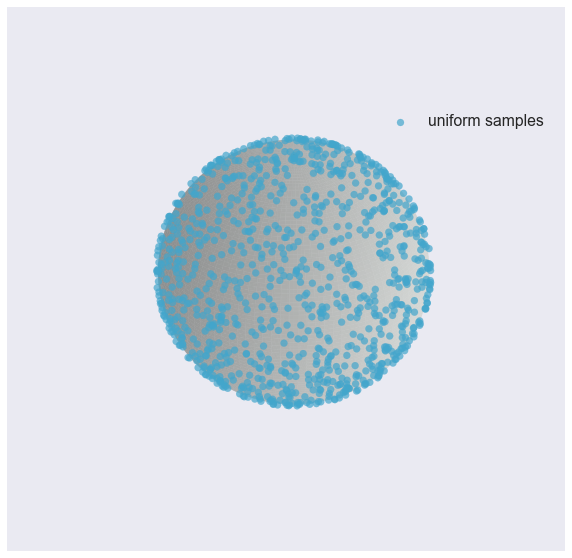

In [9]:
# unit sphere
r = 1

num_samples = 1000

# first method in link
u = np.random.uniform(0, 1, num_samples)
v = np.random.uniform(0, 1, num_samples)

theta = 2 * np.pi * u
phi = np.arccos(2 * v - 1)

# convert to cartesian and norm
x = r * np.cos(theta) * np.sin(phi) * norm
y = r * np.sin(theta) * np.sin(phi) * norm
z = r * np.cos(phi) * norm

# plot generated points on a unit * norm sphere
fig = plt.figure(figsize = [10, 10])
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(x_circ, y_circ, z_circ,  
                rstride = 1, cstride = 1, 
                color = sns.xkcd_rgb["light grey"],
                alpha = 0.5,
                linewidth = 0)
ax.scatter(x, y, z, s = 50, alpha = 0.7,
              label = 'uniform samples', color = palette[1])
ax.set_axis_off()
ax.legend(bbox_to_anchor = [0.65, 0.75])

## Simulation in Stan

Using the vMF_rng defined in `vMF.stan`.

In [10]:
import pystan
simulation = pystan.StanModel(file = 'vMF_sim.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b25e5a14fc02d0313002f4c89973b6 NOW.


In [16]:
# Use stan to simulate draws from the vMF
simu_parameters = {'N' : 1000,
                   'mu' : mu,
                   'kappa' : 100}

simu = simulation.sampling(data = simu_parameters, algorithm = "Fixed_param", 
                     iter = 1, chains = 1, seed = 19920715)


samples = simu.extract(['vMF_samples'])['vMF_samples'][0]

/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [19]:
# unit sphere
def make_sphere():
    r = 1 - 0.2 # subtract a small amount to show points on surface
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0 * pi:100j]
    x = r * sin(phi) * cos(theta)
    y = r * sin(phi) * sin(theta)
    z = r * cos(phi)
    return x, y, z

x_circ, y_circ, z_circ = make_sphere()

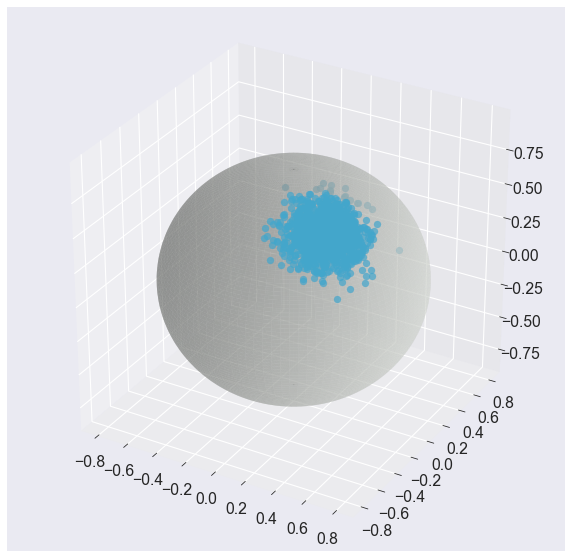

In [20]:
# plot generated points on a unit * norm sphere
fig = plt.figure(figsize = [10, 10])
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(x_circ, y_circ, z_circ,  
                rstride = 1, cstride = 1, 
                color = sns.xkcd_rgb["light grey"],
                alpha = 0.5,
                linewidth = 0)

for sample in samples:
    ax.scatter(sample[0], sample[1], sample[2], s = 50, alpha = 0.7, color = colors[1])